# BA885 Team Project
#### Christian Lawrence, Tianzheng Mao, Tiam Moradi, Phoenix Wang

To access the dataset, please add the following shared folders to your working directory:
* https://tinyurl.com/3cn2zk8u (labeled images)
* https://tinyurl.com/ypaf8wtt (unlabeled images)

# Environment Setup

In [1]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
# set working directory
import os
os.chdir("/content/gdrive/MyDrive/BA885 Team Project") # Phoenix's

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
%tensorflow_version 2.x
import PIL
import PIL.Image
import pathlib
import matplotlib.image as mpimg
from matplotlib import rcParams

# Data Setup

In [4]:
# load all the labeled images
data_dir = pathlib.Path('/content/gdrive/MyDrive/BA885 Team Project/Labeled') # Phoenix's
print('Total number of labeled images:', len(list(data_dir.glob('*/*.jpg'))))

Total number of labeled images: 17034


In [5]:
# put labeled images under their corresponding directory
labels = ['building', 'forest', 'glacier', 'mountain', 'sea', 'street']
for i in labels:
    count = len(list(data_dir.glob(i+'/*')))
    locals()[i] = list(data_dir.glob(i+'/*'))
    print(f'There are {count} images in "{i}" directory.')

There are 2628 images in "building" directory.
There are 2745 images in "forest" directory.
There are 2957 images in "glacier" directory.
There are 3037 images in "mountain" directory.
There are 2784 images in "sea" directory.
There are 2883 images in "street" directory.


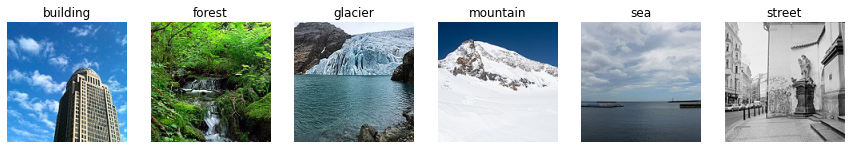

In [6]:
# display an image from each directory
rcParams['figure.figsize'] = 15, 5
fig, ax = plt.subplots(1, 6)

dirs = [building, forest, glacier, mountain, sea, street]
for i, v in enumerate(dirs):
    ax[i].imshow(PIL.Image.open(str(v[0])))
    ax[i].axis('off')
    ax[i].title.set_text(labels[i]);

In [7]:
# shape of each image
tf.keras.preprocessing.image.img_to_array(PIL.Image.open(str(building[0]))).shape

(150, 150, 3)

## Preprocessing

Use 80% of the images for training and 20% for validation.

In [8]:
batch_size = 16
img_height = 150
img_width = 150

In [9]:
# generate training set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=885,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 17034 files belonging to 6 classes.
Using 13628 files for training.


In [10]:
# generate validation set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=885,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 17034 files belonging to 6 classes.
Using 3406 files for validation.


Each batch contains 16 images of shape `(150, 150, 3)` and their corresponding labels.

In [11]:
# shape of each batch
image_batch, label_batch = next(iter(train_ds))
print(image_batch.shape)
print(label_batch.shape)

(16, 150, 150, 3)
(16,)


## Standardization

The RGB channel values are in the `[0, 255]` range. We'll standardize the values to be in the `[0, 1]` range.

In [12]:
# value range from 0 to 255
image_batch, label_batch = next(iter(train_ds))
print('Minimum value:', np.min(image_batch))
print('Maximum value:', np.max(image_batch))

Minimum value: 0.0
Maximum value: 255.0


In [13]:
standardization = tf.keras.layers.experimental.preprocessing.Rescaling(1/255)
train_ds = train_ds.map(lambda x, y: (standardization(x), y))
val_ds = val_ds.map(lambda x, y: (standardization(x), y))

In [14]:
# value range from 0 to 1
image_batch, label_batch = next(iter(train_ds))
print('Minimum value:', np.min(image_batch))
print('Maximum value:', np.max(image_batch))

Minimum value: 0.0
Maximum value: 1.0


# Model Building and Training

## Model 1
* Use 1 convolutional layer
* Use 1 hidden dense layer

In [17]:
# building model
num_classes = 6
model1 = tf.keras.Sequential([tf.keras.layers.Conv2D(32, 3, activation='relu'),
                              tf.keras.layers.MaxPooling2D(),
                              tf.keras.layers.Flatten(),
                              # fully-connected layers
                              tf.keras.layers.Dense(128, activation='relu'),
                              tf.keras.layers.Dense(num_classes)
                            ])

model1.compile(optimizer='adam',
               loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

In [18]:
# training model
epochs = 10
model1.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
852/852 [==============================] - 36s 42ms/step - loss: 1.0769 - accuracy: 0.6412 - val_loss: 0.7834 - val_accuracy: 0.7184
Epoch 2/10
852/852 [==============================] - 36s 42ms/step - loss: 0.4781 - accuracy: 0.8327 - val_loss: 0.7748 - val_accuracy: 0.7287
Epoch 3/10
852/852 [==============================] - 35s 41ms/step - loss: 0.2352 - accuracy: 0.9275 - val_loss: 1.0838 - val_accuracy: 0.7096
Epoch 4/10
852/852 [==============================] - 36s 41ms/step - loss: 0.1285 - accuracy: 0.9635 - val_loss: 1.1215 - val_accuracy: 0.7090
Epoch 5/10
852/852 [==============================] - 36s 42ms/step - loss: 0.0805 - accuracy: 0.9771 - val_loss: 1.2210 - val_accuracy: 0.7472
Epoch 6/10
852/852 [==============================] - 38s 44ms/step - loss: 0.0869 - accuracy: 0.9767 - val_loss: 1.2716 - val_accuracy: 0.7032
Epoch 7/10
852/852 [==============================] - 38s 44ms/step - loss: 0.0655 - accuracy: 0.9822 - val_loss: 1.5628 - val_accuracy:

## Model 2
* Use 3 convolutional layers
* Use 1 hidden dense layer

In [19]:
# building model
num_classes = 6
model2 = tf.keras.Sequential([tf.keras.layers.Conv2D(32, 3, activation='relu'),
                              tf.keras.layers.MaxPooling2D(),
                              tf.keras.layers.Conv2D(32, 3, activation='relu'),
                              tf.keras.layers.MaxPooling2D(),
                              tf.keras.layers.Conv2D(32, 3, activation='relu'),
                              tf.keras.layers.MaxPooling2D(),
                              tf.keras.layers.Flatten(),
                             #  tf.keras.layers.GlobalAveragePooling2D(),
                              # fully-connected layers
                              tf.keras.layers.Dense(128, activation='relu'),
                              tf.keras.layers.Dense(num_classes)
                            ])

model2.compile(optimizer='adam',
               loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

In [20]:
# training model
epochs = 10
model2.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
852/852 [==============================] - 37s 43ms/step - loss: 0.9220 - accuracy: 0.6427 - val_loss: 0.6954 - val_accuracy: 0.7566
Epoch 2/10
852/852 [==============================] - 37s 43ms/step - loss: 0.5957 - accuracy: 0.7860 - val_loss: 0.6120 - val_accuracy: 0.7824
Epoch 3/10
852/852 [==============================] - 36s 43ms/step - loss: 0.4510 - accuracy: 0.8378 - val_loss: 0.7277 - val_accuracy: 0.7522
Epoch 4/10
852/852 [==============================] - 36s 42ms/step - loss: 0.3247 - accuracy: 0.8830 - val_loss: 0.6649 - val_accuracy: 0.7995
Epoch 5/10
852/852 [==============================] - 36s 42ms/step - loss: 0.2100 - accuracy: 0.9257 - val_loss: 0.8788 - val_accuracy: 0.7863
Epoch 6/10
852/852 [==============================] - 36s 42ms/step - loss: 0.1677 - accuracy: 0.9429 - val_loss: 0.9894 - val_accuracy: 0.7754
Epoch 7/10
852/852 [==============================] - 36s 42ms/step - loss: 0.1256 - accuracy: 0.9569 - val_loss: 1.0935 - val_accuracy: